In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

# Density Estimation via Gaussian mixtures

## Objectives

+ To demonstrate density estimation via Gaussian mixtures

Again, we are going to demonstrate the concepts using a synthetic example.
Let's generate the synthetic data:

Text(0, 0.5, '$x_2$')

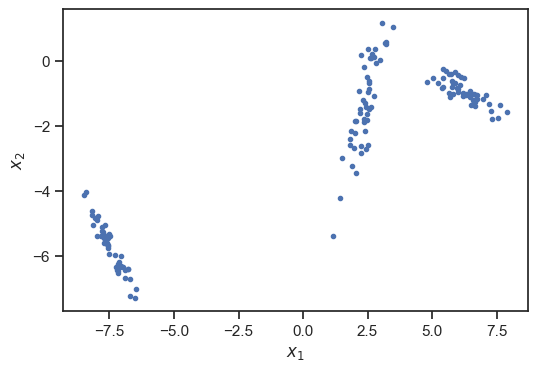

In [2]:
np.random.seed(123456)

# Make synthetic dataset for clustering
num_clusters_true = 3
# The means of each cluster
mu_true = 5.0 * np.random.randn(num_clusters_true, 2)
# The variance of the observations around the cluster
# Covariance of each cluster
Sigmas = []
for i in range(num_clusters_true):
    u = 0.5 * np.random.randn(2, 1)
    v = 0.5 * np.random.randn(2, 1)
    Sigma = np.dot(u, u.T) + np.dot(v, v.T)
    Sigmas.append(Sigma)
# How many observations to generate per cluster
num_obs_cluster = [50, 50, 50]

# Generate the data
data = []
for i in range(num_clusters_true):
    x_i = np.random.multivariate_normal(mu_true[i], Sigmas[i], 
                                        size=num_obs_cluster[i])
    data.append(x_i)
data = np.vstack(data)

# Permute the data so that order info is lost
data = np.random.permutation(data)

# Visualize
fig, ax = plt.subplots()
ax.plot(data[:, 0], data[:, 1], '.')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

We are going to use the [sciki-learn implementation](https://scikit-learn.org/stable/modules/mixture.html) of Gaussian mixtures.
Here is how you can set up a model and fit it:

In [3]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=3).fit(data)

Note that we picked 3 components for the mixture (which happens to be the true number of mixtures).
Here are the three mean vectors identified by the model:

In [4]:
model.means_

array([[ 2.401, -1.306],
       [-7.469, -5.739],
       [ 6.239, -0.938]])

Compare these to the true mean vectors:

In [5]:
mu_true

array([[ 2.346, -1.414],
       [-7.545, -5.678],
       [ 6.061, -0.866]])

The model identifies one covariance matrix per mixture component.
These are stored in a 3D array (first dimension = mixture component).
Here is how to access it:

In [6]:
model.covariances_

array([[[ 0.204,  0.538],
        [ 0.538,  1.948]],

       [[ 0.224, -0.331],
        [-0.331,  0.533]],

       [[ 0.462, -0.199],
        [-0.199,  0.135]]])

Remember that the Gaussian mixture model is essentially fitting the joint probability density function of the data, say $p(\mathbf{x})$.
In 2D, you can plot the contours of this probability density function.
As a matter of fact, we are going to plot the contours of the logarithm of the probability function, i.e., the contours of $\log p(\mathbf{x})$.
Here is how to do it.

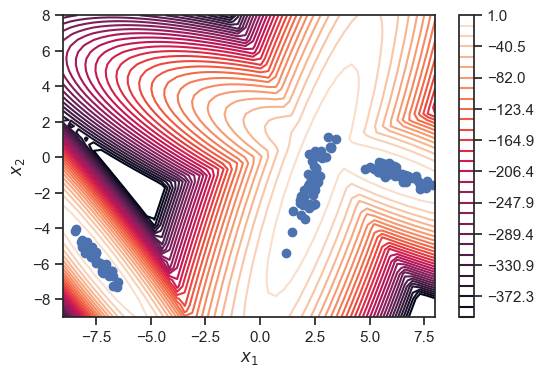

In [7]:
# Make grid
x = np.linspace(-9., 8.)
y = np.linspace(-9., 8.)
X, Y = np.meshgrid(x, y)

# Get PDF on grid points
XX = np.array([X.ravel(), Y.ravel()]).T
z = model.score_samples(XX)
Z = z.reshape(X.shape)

# Plot
fig, ax = plt.subplots()
c = ax.contour(
    X,
    Y,
    Z,
    levels=np.linspace(-400, 1.0, 30)
)
plt.colorbar(c)
plt.scatter(data[:, 0], data[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

You can also use the Gaussian mixture model to cluster the data.
Clustering is performed as following.
For each point $\mathbf{x}$ that you would like to cluster:
- calculate the probability $p_k$ that the point belongs to the $k$-th mixture component, i.e., calculate:

$$
p_k = \frac{\pi_kN(\mathbf{x}|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum_{k'=1}^K\pi_{k'}N(\mathbf{x}|\boldsymbol{\mu}_{k'},\boldsymbol{\Sigma}_{k'})}.
$$

- assign the point to the cluster $k^*$ with the highest probability, i.e.,

$$
k^* = \arg\max_{k}p_k.
$$

Scikit-learn already implements this functionality.
Here is how to do it:

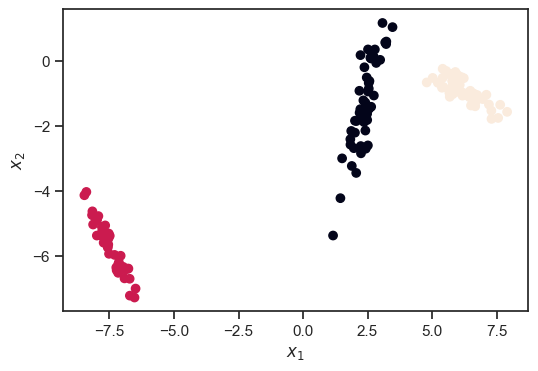

In [8]:
labels = model.predict(data)

fig, ax = plt.subplots()
plt.scatter(data[:, 0], data[:, 1], c=labels)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Another very useful thing that you can do is sample from the estimated probability density.
This can be implemented through the following procedure:
+ sample a mixture component $k$ in $1,\dots,K$, with probability $\pi_k$, i.e., sample from the Categorical random variable $\operatorname{Categorical}(\pi_1,\dots,\pi_K)$.
+ then sample an $\mathbf{x}$ from the Gaussian $N(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)$.
Again, scikit-learn implements this for you.
Here is how to access it:

Text(0, 0.5, '$x_2$')

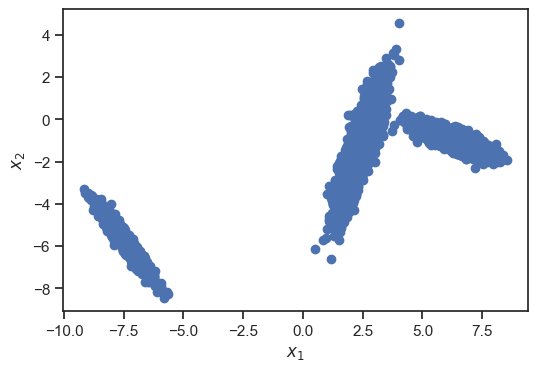

In [9]:
s_data, labels = model.sample(10000)

fig, ax = plt.subplots()
ax.scatter(s_data[:, 0], s_data[:, 1])
ax.set_xlabel('$x_1$');
ax.set_ylabel('$x_2$')

Alright! Everything works as expected when we use just the right number of components.
Let's see what happens when we use the wrong number of components.
We are going to start with fewer components than the right number.
Let's try 2 components.

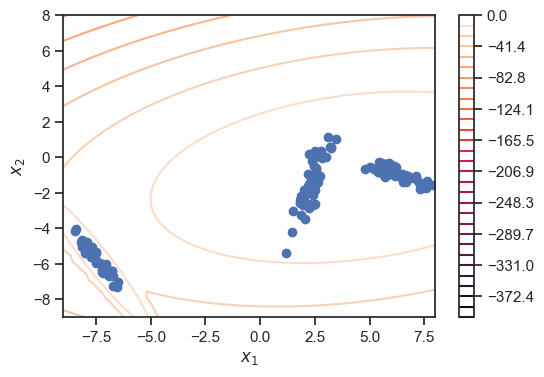

In [10]:
# Fit
model = GaussianMixture(n_components=2).fit(data)

# Plot contour of PDF
Z = model.score_samples(XX)
Z = Z.reshape(X.shape)
fig, ax = plt.subplots()
c = ax.contour(
    X,
    Y,
    Z,
    levels=np.linspace(-400, 0.0, 30)
)
plt.colorbar(c)
plt.scatter(data[:, 0], data[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Observe that the model is grouping two of the components together.
It puts them in the same Gaussian.
That's the best it can do with two components.
This is clearly underfitting.

Let's now try more components than the right number.
We are going to do 5.
Here we go:

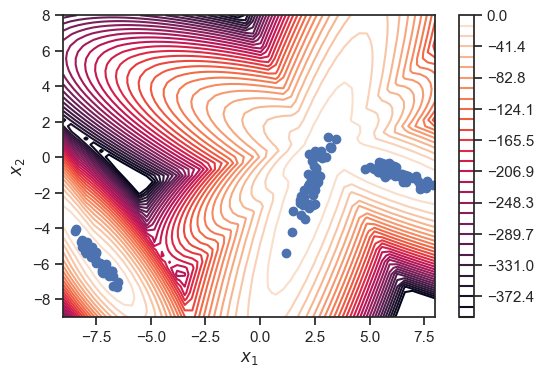

In [11]:
# Fit
model = GaussianMixture(n_components=5).fit(data)

# Plot contour of PDF
Z = model.score_samples(XX)
Z = Z.reshape(X.shape)
fig, ax = plt.subplots()
c = ax.contour(
    X,
    Y,
    Z,
    levels=np.linspace(-400, 0.0, 30)
)
plt.colorbar(c)
plt.scatter(data[:, 0], data[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

The density doesn't look very bad even though we used more components.
(The density will start looking bad if you use more components).
How does the clustering look like when we use five componets.
Let's see:

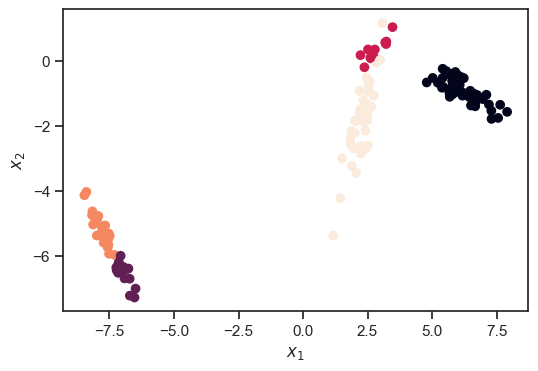

In [12]:
labels = model.predict(data)

fig, ax = plt.subplots()
plt.scatter(data[:, 0], data[:, 1], c=labels)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Okay. The model found five clusters (because we asked for them), but we can visually see in this example that it is overfitting.

Let's now apply the Bayesian information criterion (BIC) to select the number of cluster.
First, we loop over all models with 1 to 10 components and we calculate the BIC for each one of them:

In [13]:
max_num_components=10

bics = np.ndarray((max_num_components - 1,))
models = []

for nc in range(1, max_num_components):
    m = GaussianMixture(n_components=nc).fit(data)
    bics[nc - 1] = m.bic(data)
    models.append(m)

Now let's visualize the BICS:

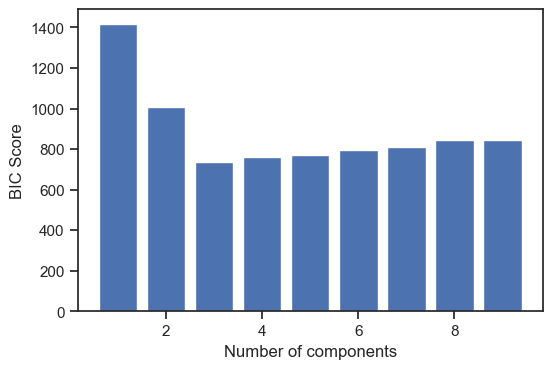

In [14]:
fig, ax = plt.subplots()
ax.bar(range(1, max_num_components), bics)
ax.set_ylabel('BIC Score')
ax.set_xlabel('Number of components');

Remember that the model with the smallest BIC is the best.
For this synthetic dataset the procedure selects 3 components which happens to be the right number.

## Questions

+ Change the random seed a couple of times (to whatever integer you want) and generate a few more examples.

+ Change the number of true components in the synthetic dataset to 5 and repeat. Does BIC work?